In [56]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import optim

# plotting
import matplotlib.pyplot as plt

# info
from torchinfo import summary
from tqdm import tqdm

# file handling
import os
from pathlib import Path

# data processing
import pandas as pd

In [3]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"running on the {device}")

running on the cpu


In [4]:
# so we can prove it works on our device

def set_seed():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)


In [121]:
# data 
data_dir = Path("C:/Users/Daniel/Documents/dataset/image-datasets/classification/lung_cancer_ct_scan")
train_dir = data_dir / "train"
test_dir = data_dir / "test"
val_dir = data_dir / "valid"

train_dir, val_dir, test_dir

(WindowsPath('C:/Users/Daniel/Documents/dataset/image-datasets/classification/lung_cancer_ct_scan/train'),
 WindowsPath('C:/Users/Daniel/Documents/dataset/image-datasets/classification/lung_cancer_ct_scan/valid'),
 WindowsPath('C:/Users/Daniel/Documents/dataset/image-datasets/classification/lung_cancer_ct_scan/test'))

In [6]:
# convert train, val and test data into torch datasets

# data for transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# i switched the validation and test set so there is more data in val than test

train_dataset = ImageFolder(train_dir, 
                           transform=transform)
test_dataset = ImageFolder(val_dir,
                         transform=transform)
val_dataset = ImageFolder(test_dir,
                         transform=transform)

In [7]:
class_names = train_dataset.classes
class_names

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [8]:
len_train = len(train_dataset)
len_val = len(val_dataset)
len_test = len(test_dataset)

print(f"length of train set: {len_train}\nlength of validation set: {len_val}\nlength of test set: {len_test}")

length of train set: 612
length of validation set: 315
length of test set: 72


In [9]:
# convert dataset to dataloaders
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=os.cpu_count())

val_dataloader = DataLoader(val_dataset, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True, 
                            num_workers=os.cpu_count())

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                             shuffle=True, 
                             num_workers=os.cpu_count())

print(f"train dataloader has {len(train_dataloader)} batches\nvalidation dataloader has {len(val_dataloader)} batches\ntest dataloader has {len(test_dataloader)} batches")

train dataloader has 20 batches
validation dataloader has 10 batches
test dataloader has 3 batches


In [10]:
# get random smaples from the dataset to visualize
images, labels = next(iter(train_dataloader))

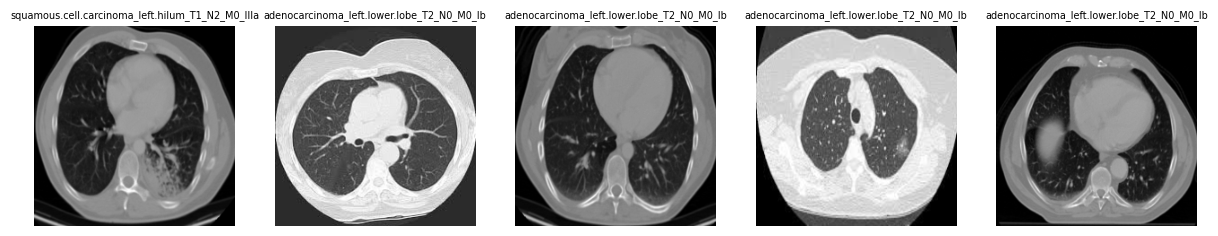

In [11]:
# plot random samples
samples = torch.randint(0, len(train_dataloader), size=[5])

fig, axs = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(15,7))
for i in range(len(samples)):
    axs[i].imshow(images[samples[i]].permute(1,2,0), cmap="gray")
    axs[i].set_title(class_names[labels[samples[i]]], fontsize=7)
    axs[i].axis(False)


In [14]:
targets = train_dataset.targets
targets = pd.Series(targets)
targets = targets.value_counts()
print(f"number of samples per class:")

for i in range(len(targets)):
    class_distribution = {class_names[i]:num for i, num in enumerate(targets)}
    
class_distribution = pd.Series(class_distribution)
print(class_distribution)

number of samples per class:
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib          194
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       155
normal                                              148
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa    115
dtype: int64


In [15]:
# model
class BaseLine(nn.Module):
    def __init__(self, in_channels:int=1, hidden_units=10, num_classes:int=4):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=(4,4), stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(4,4), stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(4,4), stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*28*28, out_features=num_classes)            
        )

    def forward(self, x):
        return self.layer_stack(x)

In [16]:
set_seed()
model_0 = BaseLine()
model_0

BaseLine(
  (layer_stack): Sequential(
    (0): Conv2d(1, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=7840, out_features=4, bias=True)
  )
)

In [17]:
dummy_data = torch.rand(1,1,224,224)
output = model_0(dummy_data)
output

tensor([[ 0.0566,  0.0555, -0.0296,  0.0090]], grad_fn=<AddmmBackward0>)

In [18]:
# setup optimizer and loss function
optimizer = optim.Adam(model_0.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [19]:
# model accuracy cuntion
def accuracy(y_pred, y_true):
    acc = torch.eq(y_pred, y_true).sum().item()
    return (acc / len(y_true)) * 100


In [26]:
# train and test loop
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = 0, 0
    
    model_0.train()
    for batch, (X_train, y_train) in tqdm(enumerate(train_dataloader)):
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        # forward prop
        logits = model_0(X_train)
        loss = criterion(logits, y_train)
        
        # train loss and accuracy
        train_loss += loss
        train_acc += accuracy(torch.argmax(logits, dim=1), y_train)
        
        optimizer.zero_grad() # prevent gradients from accumulating
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)


    
    # evaluate the model
    model_0.eval()
    with torch.inference_mode():
        val_loss, val_acc = 0, 0
        for X_val, y_val in val_dataloader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            y_pred_logits = model_0(X_val)
            part_val_loss = criterion(y_pred_logits, y_val)
            val_loss += part_val_loss
            val_acc += accuracy(torch.argmax(y_pred_logits, dim=1), y_val)

    

        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        print(f"epoch: {epoch + 1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")

20it [00:06,  3.20it/s]


epoch: 1 | train_loss: 1.3843 | train_acc: 29.53% | val_loss: 1.3586 | val_acc: 38.08%


20it [00:05,  3.39it/s]


epoch: 2 | train_loss: 1.3692 | train_acc: 32.50% | val_loss: 1.3561 | val_acc: 38.08%


20it [00:17,  1.17it/s]


epoch: 3 | train_loss: 1.3942 | train_acc: 28.12% | val_loss: 1.3737 | val_acc: 16.99%


20it [00:36,  1.85s/it]


epoch: 4 | train_loss: 1.3987 | train_acc: 28.44% | val_loss: 1.3638 | val_acc: 38.19%


20it [00:28,  1.42s/it]


epoch: 5 | train_loss: 1.3741 | train_acc: 31.09% | val_loss: 1.3674 | val_acc: 16.99%


20it [00:21,  1.09s/it]


epoch: 6 | train_loss: 1.3820 | train_acc: 30.16% | val_loss: 1.3948 | val_acc: 17.22%


20it [00:07,  2.83it/s]


epoch: 7 | train_loss: 1.3772 | train_acc: 27.50% | val_loss: 1.3471 | val_acc: 38.02%


20it [00:05,  3.40it/s]


epoch: 8 | train_loss: 1.3733 | train_acc: 31.25% | val_loss: 1.3489 | val_acc: 38.19%


20it [00:06,  3.33it/s]


epoch: 9 | train_loss: 1.3738 | train_acc: 32.50% | val_loss: 1.3514 | val_acc: 38.19%


20it [00:05,  3.36it/s]


epoch: 10 | train_loss: 1.3715 | train_acc: 31.41% | val_loss: 1.3461 | val_acc: 38.14%


In [152]:
# using a pretrained model
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
effnet_model = torchvision.models.efficientnet_b1(weights=weights)
effnet_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [153]:
# use the foundation model's transforms on the dataset
effnet_transforms = weights.transforms()
p_transforms = transforms.Compose([
    transforms.ToTensor(),
    effnet_transforms,
])

# create datasets with foundation model's transforms
p_train_dataset = ImageFolder(train_dir, transform=p_transforms)
p_val_dataset = ImageFolder(test_dir, transform=p_transforms)
p_test_dataset = ImageFolder(val_dir, transform=p_transforms)

# create dataloaders
BATCH_SIZE = 32
p_train_dataloader = DataLoader(p_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
p_val_dataloader = DataLoader(p_val_dataset, batch_size=BATCH_SIZE, num_workers=os.cpu_count())
p_test_dataloader = DataLoader(p_test_dataset, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

print(f"length of train_dataloader: {len(p_train_dataloader)}\nlength of val_dataloader: {len(p_val_dataloader)}\nlength of test_dataloader: {len(p_test_dataloader)}")

length of train_dataloader: 20
length of val_dataloader: 10
length of test_dataloader: 3


In [154]:
p_transforms

Compose(
    ToTensor()
    ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [136]:
images, labels = next(iter(p_val_dataloader))

In [158]:
images[0].shape # required input shape for efficient net model

torch.Size([3, 240, 240])

In [155]:
summary(model=effnet_model, input_size=(1,3,240,240), 
        row_settings=["ascii_only", "var_names",], 
        col_names=["input_size","output_size","trainable"])

Layer (type (var_name))                                      Input Shape               Output Shape              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 240, 240]          [1, 1000]                 True
+ Sequential (features)                                      [1, 3, 240, 240]          [1, 1280, 8, 8]           True
|    + Conv2dNormActivation (0)                              [1, 3, 240, 240]          [1, 32, 120, 120]         True
|    |    + Conv2d (0)                                       [1, 3, 240, 240]          [1, 32, 120, 120]         True
|    |    + BatchNorm2d (1)                                  [1, 32, 120, 120]         [1, 32, 120, 120]         True
|    |    + SiLU (2)                                         [1, 32, 120, 120]         [1, 32, 120, 120]         --
|    + Sequential (1)                                        [1, 32, 120, 120]         [1, 16, 120, 120]         True
|    |    + MBConv (0)                               

In [156]:
# freeze weights
for params in effnet_model.features.parameters():
    params.requires_grad = False

In [157]:
# tweak classifier layer outputs to fit out data
effnet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=4, bias=True)
)

In [159]:
summary(model=effnet_model, input_size=(1,3,240,240), 
        row_settings=["ascii_only", "var_names",], 
        col_names=["input_size","output_size","trainable"])

Layer (type (var_name))                                      Input Shape               Output Shape              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 240, 240]          [1, 4]                    True
+ Sequential (features)                                      [1, 3, 240, 240]          [1, 1280, 8, 8]           True
|    + Conv2dNormActivation (0)                              [1, 3, 240, 240]          [1, 32, 120, 120]         True
|    |    + Conv2d (0)                                       [1, 3, 240, 240]          [1, 32, 120, 120]         True
|    |    + BatchNorm2d (1)                                  [1, 32, 120, 120]         [1, 32, 120, 120]         True
|    |    + SiLU (2)                                         [1, 32, 120, 120]         [1, 32, 120, 120]         --
|    + Sequential (1)                                        [1, 32, 120, 120]         [1, 16, 120, 120]         True
|    |    + MBConv (0)                               

In [160]:
def accuracy(y_pred, y_true):
    acc = torch.eq(y_pred, y_true).sum().item()
    return (acc / len(y_true)) * 100

# rand_1 = torch.rand(5)
# accuracy(rand_1, rand_1)

In [162]:
# setup loss funtion and optimizer
optimizer = optim.Adam(effnet_model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [ ]:
EPOCH = 2

for epoch in range(EPOCHS):
    for batch, (X_train, y_train) in tqdm(enumerate(p_train_dataloader)):
        X_train, y_train = X_train.to(device), y_train.to(device)
        train_loss, train_acc = 0, 0
        
        effnet_model.train()
        # forward pass
        logits = effnet_model(X_train)
        # compute loss
        loss = criterion(logits, y_train)
        train_loss += loss
        train_acc = accuracy(torch.argmax(logits, dim=1), y_train)

        # prevent gradients from accumulating
        optimizer.zero_grad()
        # bakward pass
        loss.backward()
        # gradient descent
        optimizer.step()
    train_loss /= len(p_train_dataloader)
    train_acc /= len(p_train_dataloader)

    # model evaluation
    effnet_model.eval()
    with torch.inference_mode():
        val_loss, val_acc = 0, 0
        for X_val, y_val in p_val_dataloader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            y_pred_logits = effnet_model(X_val)
            eval_loss = criterion(y_pred_logits, y_val)
            val_loss += eval_loss
            val_acc += accuracy(torch.argmax(y_pred_logits, dim=1), y_val)

        val_loss /= len(p_val_dataloader)
        val_acc /= len(p_val_dataloader)
        print(f"epoch {epoch + 1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")